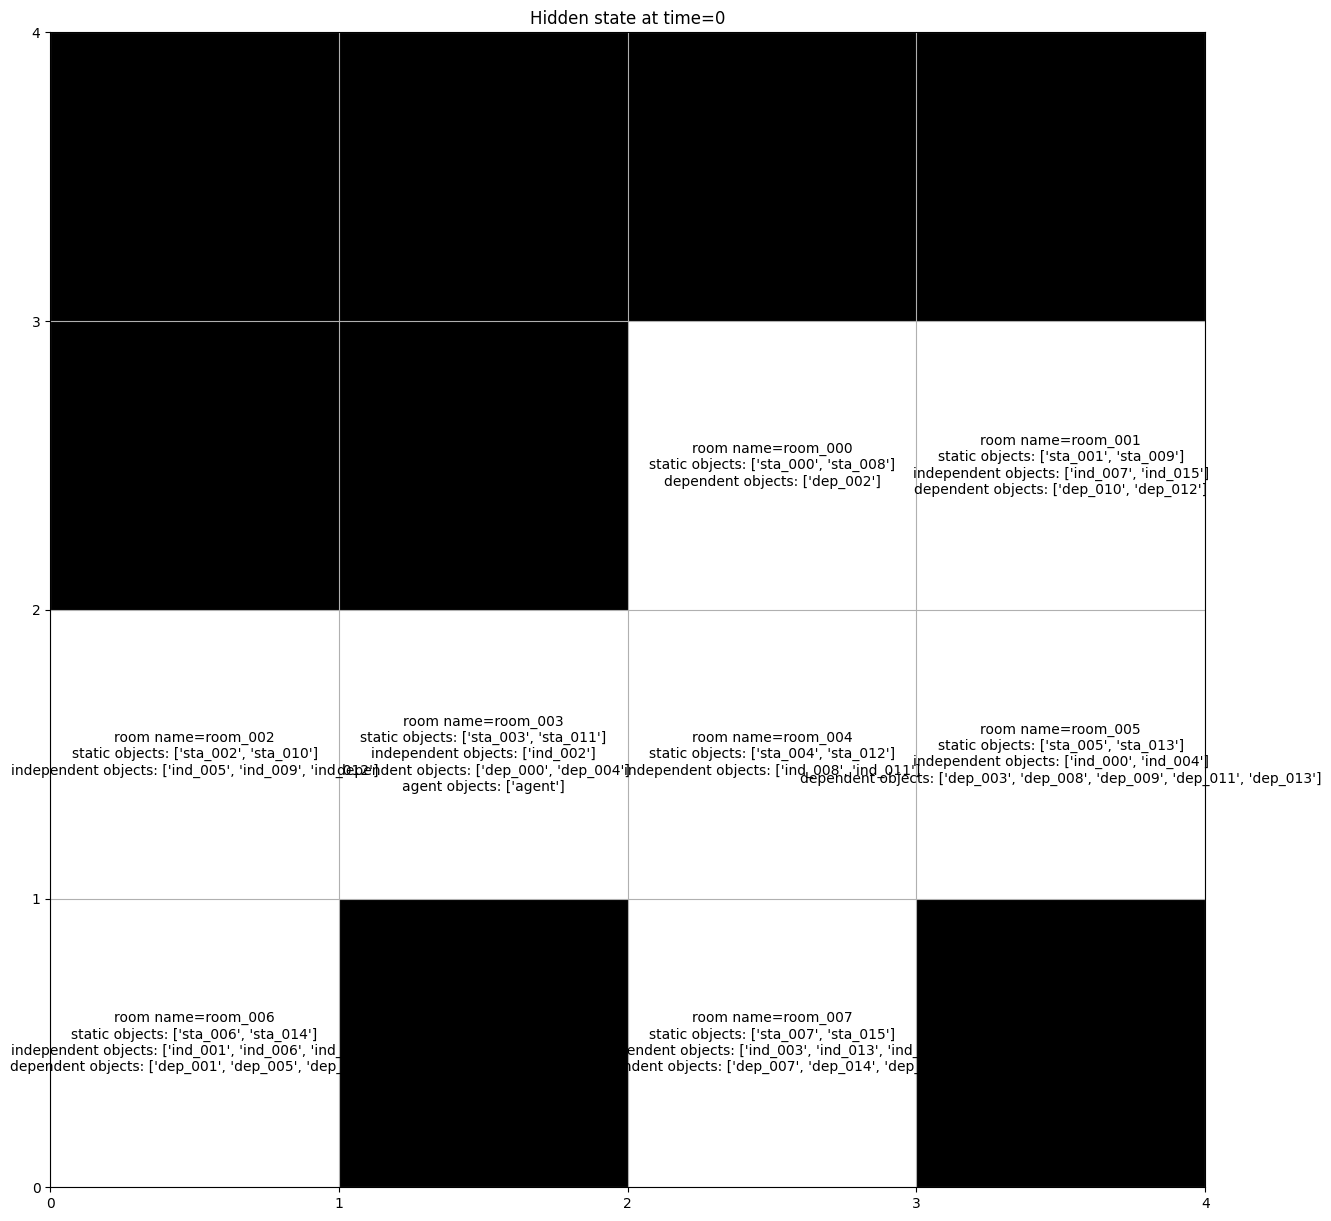

The number of room: 8
The number of static_objects: 16
The number of independent_objects: 16
The number of dependent_objects: 16

memory mgmt         qa                  explore             pretrain_semantic   mean      std       
--------------------------------------------------------------------------------------------------------------
random              episodic_semantic   avoid_walls         False               -4.44     0.32      
random              episodic_semantic   avoid_walls         True                -5.28     0.52      
random              episodic_semantic   random              False               -5.68     0.74      
random              episodic_semantic   random              True                -5.68     0.74      


In [11]:
from agent import HandcraftedAgent
from tqdm.auto import tqdm
import numpy as np
import random
import logging
from room_env.envs.room2 import RoomEnv2

logger = logging.getLogger()
logger.disabled = True

room_size = "l"

capacity = {
    "episodic": 32,
    "episodic_agent": 32,
    "semantic": 32,
    "semantic_map": 32,
    "short": 1,
}

config = {
    "question_prob": 1.0,
    "seed": 0,
    "terminates_at": 9,
    "randomize_observations": True,
    "room_size": room_size,
    "deterministic_init": True,
}

results = {}

for mm_policy in ["random"]:
    for qa_policy in ["episodic_semantic"]:
        for explore_policy in ["avoid_walls", "random"]:
            for pretrain_semantic in [False, True]:
                key = (
                    mm_policy,
                    qa_policy,
                    explore_policy,
                    pretrain_semantic,
                )
                if key not in results:
                    results[key] = []
                print(key)

                for seed in tqdm([0, 1, 2, 3, 4]):
                    config["seed"] = seed

                    agent = HandcraftedAgent(
                        env_str="room_env:RoomEnv-v2",
                        env_config=config,
                        mm_policy=mm_policy,
                        qa_policy=qa_policy,
                        explore_policy=explore_policy,
                        num_samples_for_results=10,
                        capacity=capacity,
                        pretrain_semantic=pretrain_semantic,
                    )
                    agent.test()
                    agent.remove_results_from_disk()
                    to_append = (np.mean(agent.scores), np.std(agent.scores))
                    # print(to_append)
                    results[key].append(to_append)


env = RoomEnv2(**config)
observations, info = env.reset()
env.render("image")
for key, val in env.names.items():
    print(f"The number of {key}: {len(val)}")

print(
    f"\n{'memory mgmt':<20}{'qa':<20}{'explore':<20}{'pretrain_semantic':<20}{'mean':<10}{'std':<10}"
)
print(f"-" * 110)
for key, val in results.items():
    print(
        f"{str(key[0]):<20}{str(key[1]):<20}{str(key[2]):<20}{str(key[3]):<20}{round(np.mean([v[0] for v in val]), 2):<10}{round(np.std([v[0] for v in val]), 2):<10}"
    )

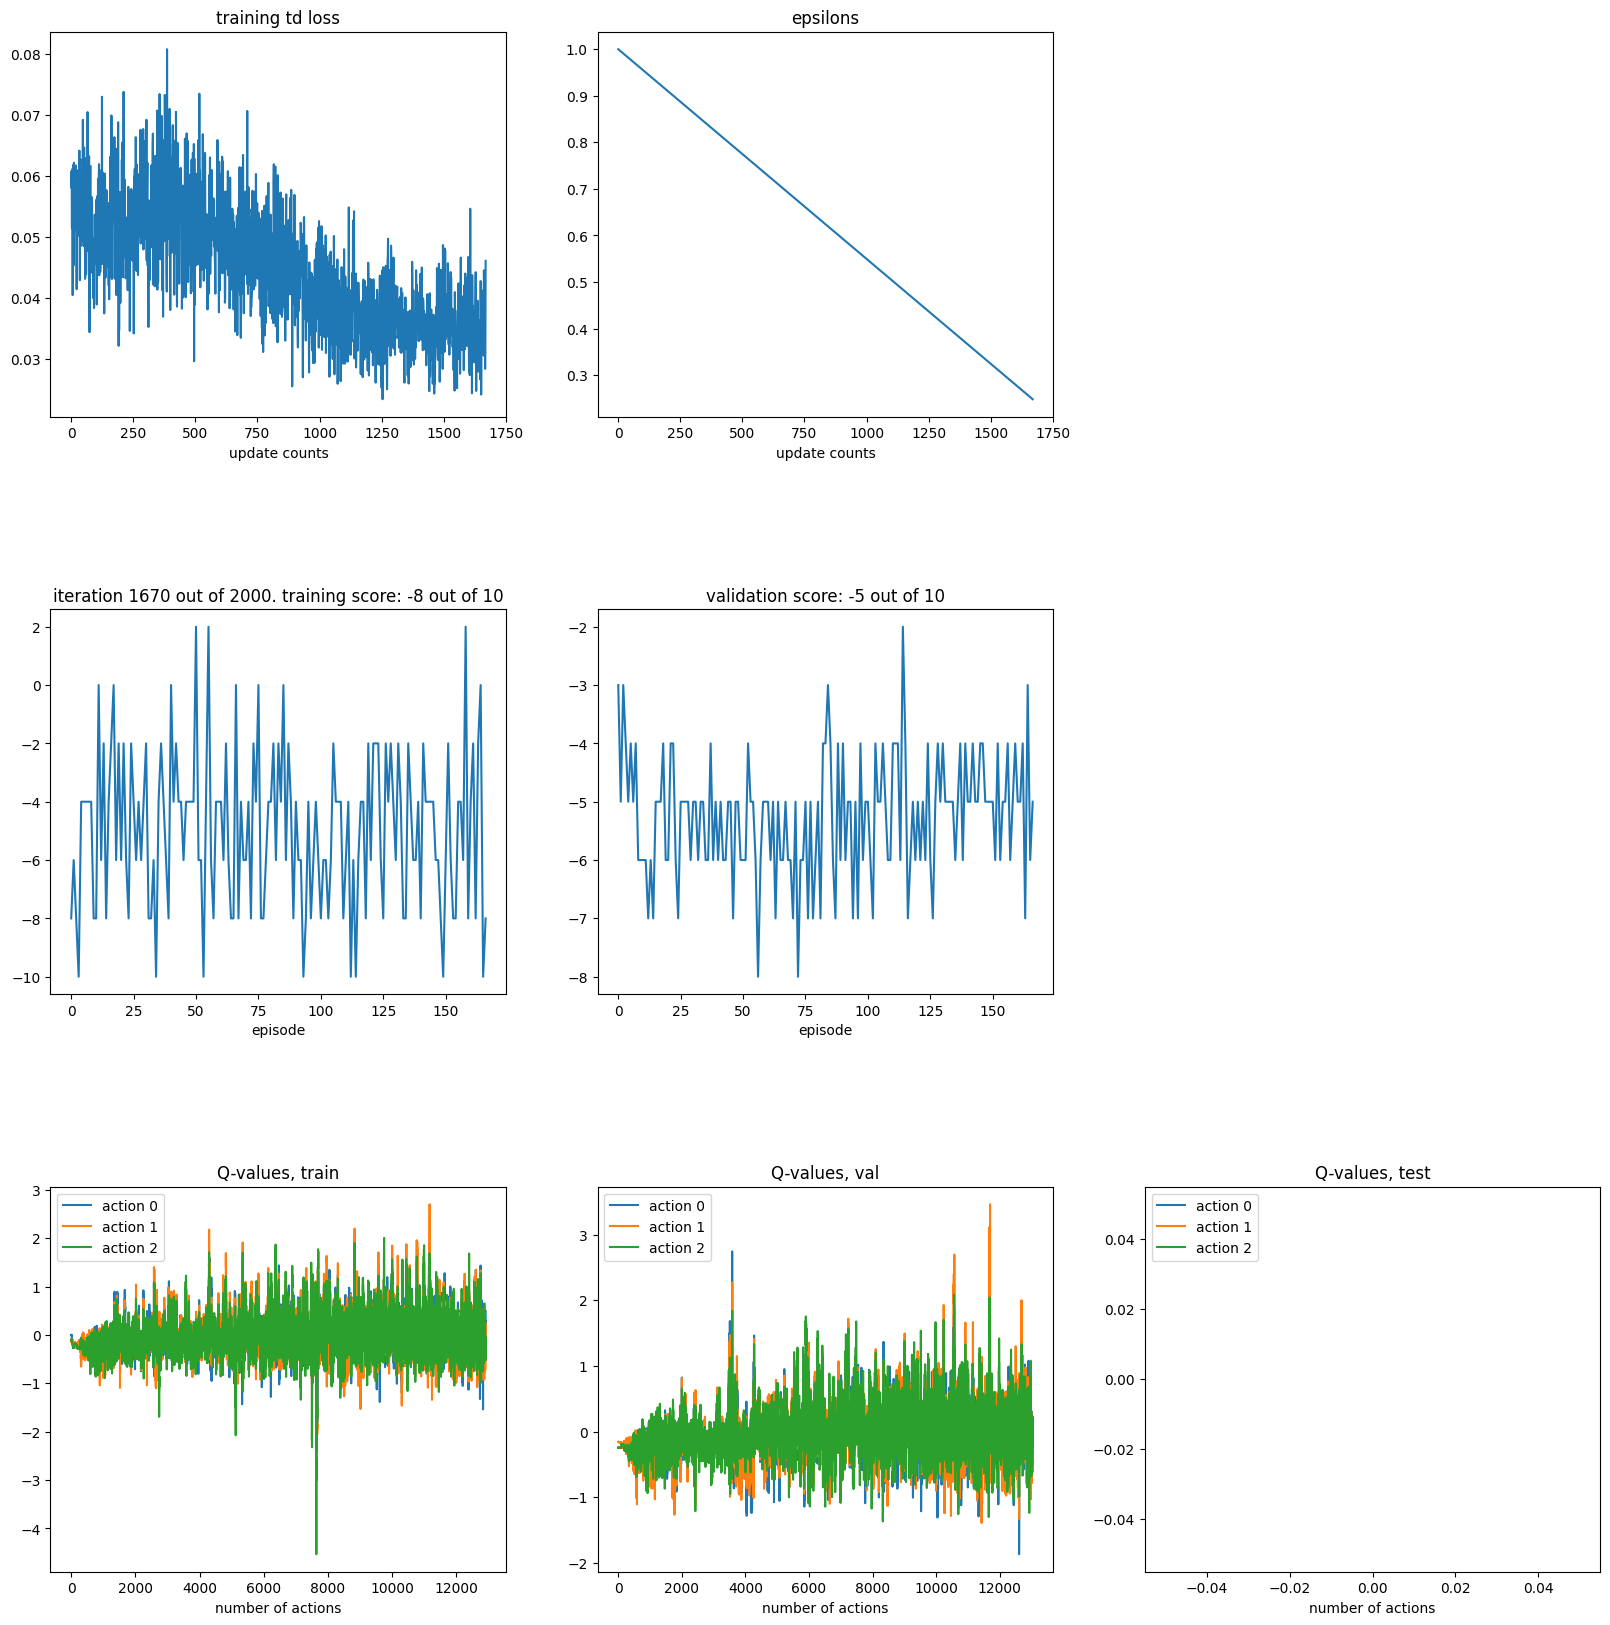

/home/tk/.virtualenvs/human-memory/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.return_room_layout to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.return_room_layout` for environment variables or `env.get_wrapper_attr('return_room_layout')` that will search the reminding wrappers.
  logger.warn(


In [15]:
from agent.dqn import DQNMMAgent
import random
import logging

logger = logging.getLogger()
logger.disabled = True

for seed in [0, 1, 2, 3, 4]:
    for pretrain_semantic in [False, True]:
        all_params = {
            "env_str": "room_env:RoomEnv-v2",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 10 * 200,
            "gamma": 0.7,
            "capacity": capacity,
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "embedding_dim": 32,
                "v1_params": None,
                "v2_params": {},
                "memory_of_interest": [
                    "episodic",
                    "semantic",
                    "short",
                ],
            },
            "num_iterations": 10 * 200,
            "replay_buffer_size": 256 * 10,
            "warm_start": 256,
            "batch_size": 256,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": seed,
            "qa_policy": "episodic_semantic",
            "explore_policy": "avoid_walls",
            "env_config": config,
            "ddqn": True,
            "dueling_dqn": True,
            "split_reward_training": False,
            "default_root_dir": "./training_results/room-size=l",
        }

        agent = DQNMMAgent(**all_params)
        agent.train()